# Basic Clustering

Grouping data by some simple category is not always feasible or practical. Sometimes we have data that is numerical with no clear means of grouping. Numerically grouping data is what we refer to as clustering, and there are many algorithms and routines to accomplish it.

`scikit-learn` makes clustering data extremely easy. Here we will first take a look at how clustering works, and then see how easy it is to perform in `scikit-learn`.

## K-Means Clustering

Clustering algorithms apply a statistical process to a set of points that usually includes computing some sort of metric. This metric could be based on distances between points or centroids, density of regions, or even based on distributions of the data. There are many methods for performing clustering.

We are going to start simple, and implement and test out some methods based on centroid distances. We are going to start with some dummy data provided to us by `scikit-learn`.

We use the `make_blobs` function to create a set of 600 data points with 5 clusters. When we visualize the data set we can loosely see the clusters. However, at the boundaries of the clusters that are adjacent, it is difficult to determine which points belong to which cluster.

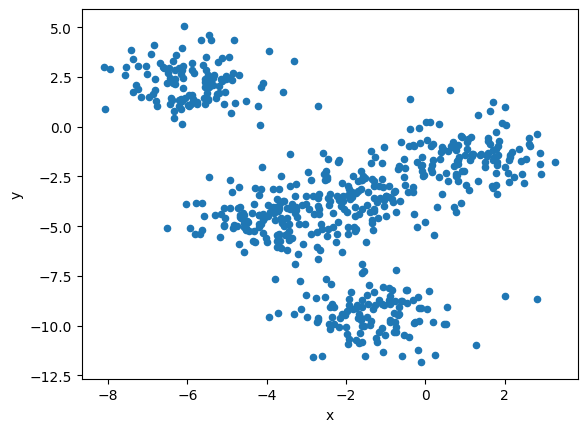

In [1]:
import pandas as pd
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=600, centers=5, random_state=2)
_data = X.reshape((600, 2)).T

data = pd.DataFrame({"x": _data[0], "y": _data[1]})

ax = data.plot.scatter(x="x", y="y")

To partition the data into clusters, we are going to use the `k-means` clustering algorithm. This is a centroid based method that iteratively groups points by their distances to centroids within the data space. To start this off, we need to initialize our algorithm with some some centroids. We are going to randomly select 5 points without our set and chose them as the centroids. This is called the `Forgy` method.

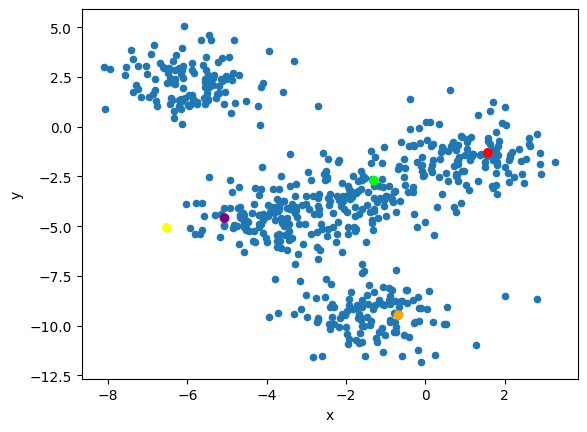

In [2]:
import numpy as np

np.random.seed(0)
_centroids = X[np.random.randint(0, 600, size=5)]
centroids = _centroids.reshape((5, 2)).T
ax.scatter(
    centroids[0], centroids[1], c=["purple", "red", "orange", "yellow", "lime"]
)
ax.figure

These 5 points (we selected 5, since we expect there to be 5 clusters found) are just randomly chosen. This means that our final cluster assignment is likely to be suboptimal, and furthermore it is not guaranteed to run quickly.

Regardless, we can proceed. Next we need to then determine which centroid is closest for each point. We are going to define a new function to help compute the closest centroid.

This function `find_closet_centroid` returns the index of the centroid it is closest to. It uses `numpy's` function `np.linalg.norm` to compute the distances, and then uses `np.argmin` to find the index of the smallest distance.

In [3]:
def find_closet_centroid(point):
    distances = [
        np.linalg.norm(centroid - (point.x, point.y))
        for centroid in _centroids
    ]
    return np.argmin(distances)


data["closest_centroid"] = data.apply(find_closet_centroid, axis=1)
data.groupby("closest_centroid").count()

,x,y
closest_centroid,,
0,170,170
1,104,104
2,119,119
3,5,5
4,202,202


We can see that our cluster assignment is not very uniform, and in fact appears be fairly lopsided. We can create a custom colormap and then color each point based on the centroid it belongs to.

<Axes: xlabel='x', ylabel='y'>

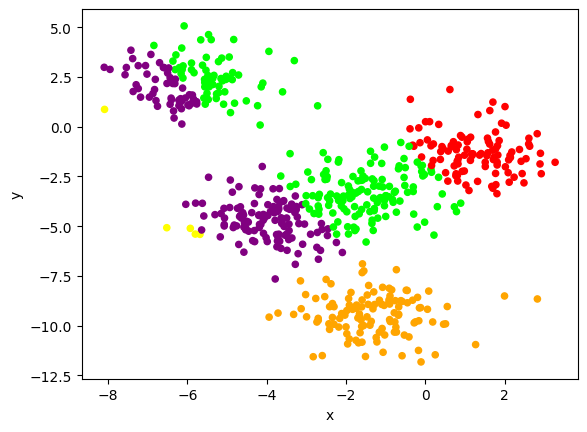

In [4]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap(["purple", "red", "orange", "yellow", "lime"])
data.plot.scatter(
    x="x", y="y", c="closest_centroid", cmap=cmap, colorbar=False
)

This is not so great though as we know that our clusters should be fairly uniform, and the cluster in the bottom right is meant to be a single cluster. We need to iterate, recomputing centroids based on the new clusters found.

We create a new function `compute_centroid` that just takes the means of x and y values of each cluster. We use `groupby` to grab all of the points found in each cluster and then overwrite the centroids list.

In [5]:
def compute_centroid(cluster):
    return np.array([cluster.x.mean(), cluster.y.mean()])


for cluster_index, cluster in data.groupby("closest_centroid"):
    _centroids[cluster_index] = compute_centroid(cluster)

centroids = _centroids.reshape((5, 2)).T
_centroids

array([[-4.79171001, -2.69803812],
       [ 1.29241262, -1.31316661],
       [-1.31442768, -9.43104622],
       [-6.40512228, -4.02617223],
       [-2.74017378, -1.39337   ]])

We can re-plot our initial dataset with the new centroids to see how things changed.

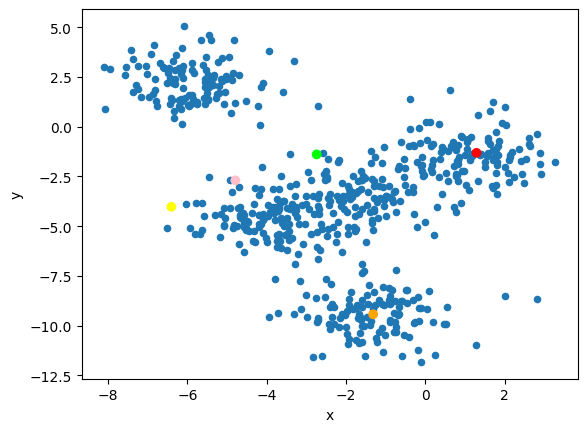

In [6]:
ax = data.plot.scatter(x="x", y="y")
ax.scatter(
    centroids[0], centroids[1], c=["pink", "red", "orange", "yellow", "lime"]
)

And if we recolor our points...

<Axes: xlabel='x', ylabel='y'>

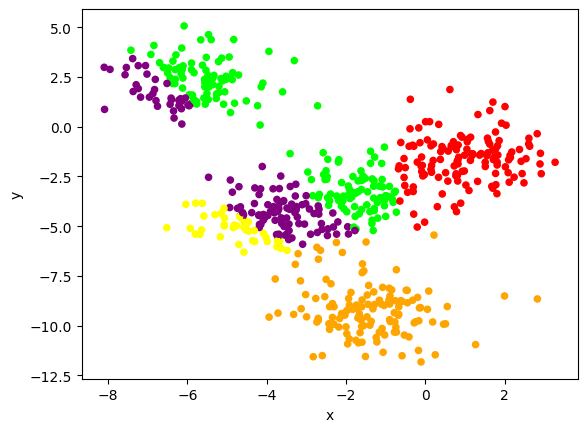

In [7]:
data["closest_centroid"] = data.apply(find_closet_centroid, axis=1)
data.plot.scatter(
    x="x", y="y", c="closest_centroid", cmap=cmap, colorbar=False
)

After just one iteration our cluster assignments are looking much better. We can continue to iterate a few more times and we can see that just a few more iterations gives us a pretty good cluster assignment. The general process involves iterating until the shift in centroids is less than some threshold.

<Axes: xlabel='x', ylabel='y'>

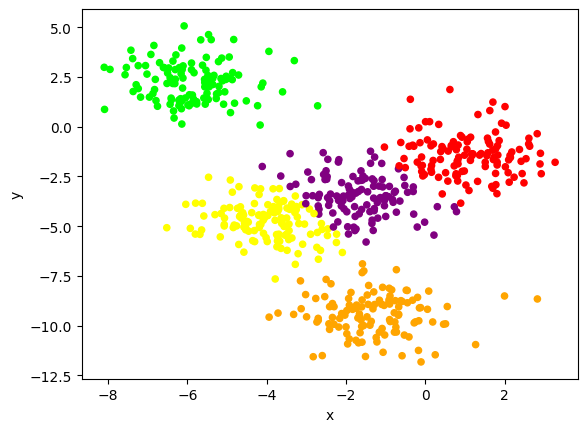

In [8]:
for index in range(5):
    for cluster_index, cluster in data.groupby("closest_centroid"):
        _centroids[cluster_index] = compute_centroid(cluster)
    data["closest_centroid"] = data.apply(find_closet_centroid, axis=1)
data.plot.scatter(
    x="x", y="y", c="closest_centroid", cmap=cmap, colorbar=False
)

Another initialization method called the `Random Partition` method requires us to assign a random cluster to each our points and compute our initial centroids that way. From there we iterate all the same. This suffers from similar performance issues.

However, there is no need to actually perform this manually. We can use `scikit-learn` to compute this for us!

<Axes: xlabel='x', ylabel='y'>

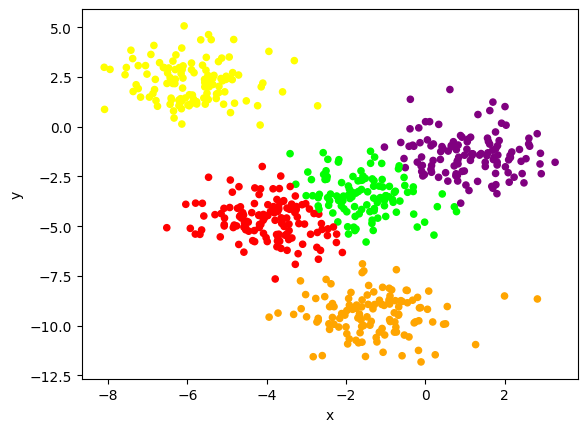

In [9]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=5, random_state=2).fit_predict(X)
data.plot.scatter(x="x", y="y", c=k_means, cmap=cmap, colorbar=False)

`scikit-learn` provides a number of clustering algorithm implementations - different algorithms have different use cases, fidelity, and performance. Check them out [here](https://scikit-learn.org/stable/modules/clustering.html).